### Deepweeds data synthesis using AC-GAN

Source: https://github.com/clvrai/ACGAN-PyTorch/blob/master/main.py

In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

In [2]:
os.makedirs("gen_images", exist_ok=True)

n_epochs = 200
batch_size = 64
lr =0.0002
b1 =0.5
b2 = 0.999
n_cpu =8
latent_dim = 100
n_classes = 9
img_size = 128
channels = 3
sample_interval = 800


cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
# Root directory for dataset
dataroot = "data/train"



dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "gen_images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
            sample_image(n_row=10, batches_done=batches_done)

C:\Users\rashe\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch 0/350] [Batch 0/273] [D loss: 1.497794, acc: 10%] [G loss: 1.500304]
[Epoch 2/350] [Batch 254/273] [D loss: 1.363768, acc: 42%] [G loss: 1.385221]
[Epoch 5/350] [Batch 235/273] [D loss: 1.333434, acc: 48%] [G loss: 1.348099]
[Epoch 8/350] [Batch 216/273] [D loss: 1.399851, acc: 39%] [G loss: 1.410127]
[Epoch 11/350] [Batch 197/273] [D loss: 1.371487, acc: 40%] [G loss: 1.417656]
[Epoch 14/350] [Batch 178/273] [D loss: 1.339059, acc: 46%] [G loss: 1.421442]
[Epoch 17/350] [Batch 159/273] [D loss: 1.294952, acc: 55%] [G loss: 1.332938]
[Epoch 20/350] [Batch 140/273] [D loss: 1.383454, acc: 40%] [G loss: 1.370650]
[Epoch 23/350] [Batch 121/273] [D loss: 1.360011, acc: 43%] [G loss: 1.406226]
[Epoch 26/350] [Batch 102/273] [D loss: 1.316031, acc: 50%] [G loss: 1.318929]
[Epoch 29/350] [Batch 83/273] [D loss: 1.328660, acc: 47%] [G loss: 1.368257]
[Epoch 32/350] [Batch 64/273] [D loss: 1.302523, acc: 56%] [G loss: 1.285599]
[Epoch 35/350] [Batch 45/273] [D loss: 1.287301, acc: 64%] [

[Epoch 304/350] [Batch 208/273] [D loss: 1.175698, acc: 79%] [G loss: 1.076540]
[Epoch 307/350] [Batch 189/273] [D loss: 1.154095, acc: 86%] [G loss: 1.095764]
[Epoch 310/350] [Batch 170/273] [D loss: 1.148216, acc: 87%] [G loss: 1.077279]
[Epoch 313/350] [Batch 151/273] [D loss: 1.141712, acc: 86%] [G loss: 1.070026]
[Epoch 316/350] [Batch 132/273] [D loss: 1.164015, acc: 84%] [G loss: 1.088692]
[Epoch 319/350] [Batch 113/273] [D loss: 1.154827, acc: 85%] [G loss: 1.075160]
[Epoch 322/350] [Batch 94/273] [D loss: 1.165272, acc: 84%] [G loss: 1.074965]
[Epoch 325/350] [Batch 75/273] [D loss: 1.146015, acc: 87%] [G loss: 1.065957]
[Epoch 328/350] [Batch 56/273] [D loss: 1.138810, acc: 89%] [G loss: 1.076407]
[Epoch 331/350] [Batch 37/273] [D loss: 1.143299, acc: 88%] [G loss: 1.075613]
[Epoch 334/350] [Batch 18/273] [D loss: 1.137874, acc: 86%] [G loss: 1.093330]
[Epoch 336/350] [Batch 272/273] [D loss: 1.172933, acc: 84%] [G loss: 1.063319]
[Epoch 339/350] [Batch 253/273] [D loss: 1.13

#### Analysis: the model accuracy reached 85% 193 and statyed close to that value afterwards  - meaning 200 epochs is sufficient for future training

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

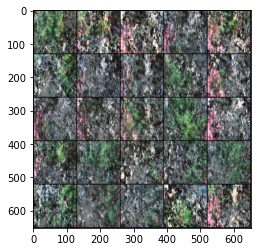

In [9]:
#display some images of label 8 (negative weeds)
n_row = 5
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
labels = np.array([1 for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)


show_tensor_images(gen_imgs, 25, (128,128))


In [7]:
# Saving the generator model

# Create folder to save model
MODEL_FOLDER = "Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/deepweeds_acgan_gan.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(generator.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at Model/deepweeds_acgan_gan.pth


#### Generate traning images

In [15]:
image_dir = 'data/data_gen/train/'

#geneerate five images for each label at a time and save them in the above directory ... 100 times
n_row = 5
for i in range(10):
    for nclass in range(9):
        z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
        # Get labels ranging from 0 to n_classes for n rows
        labels = np.array([nclass for _ in range(n_row) for num in range(n_row)])
        labels = Variable(LongTensor(labels))
        gen_imgs = generator(z, labels)
        for idx in range(gen_imgs.data.shape[0]):
            img_name = image_dir + str(nclass) + "/" + f"{i}000" + str(nclass) + str(idx) + ".png"
            save_image(gen_imgs.data[idx], img_name, nrow=1, normalize=True)

    

KeyboardInterrupt: 